# Plot snapshots of $q$ and EKE fields with particles in them

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from numpy.fft import irfft2
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmocean as cmo
import seaborn as sns

In [2]:
#%% Coordinates
x = np.load("../../Results/Results_GeophysicalFlows/x.npy")
y = np.load("../../Results/Results_GeophysicalFlows/y.npy")

In [3]:
slope = '-3e-3'
field = '3'
run = '9'

In [6]:
#%% Reading in the potential vorticity field

def get_qhi(qhi):
    sh = qhi.shape
    qhiZ = np.empty(sh, dtype=np.complex64)
    for i in range(sh[0]):
        for j in range(sh[1]):
            for k in range(sh[2]):
                zijk = qhi[i, j, k]
                qhiZ[i, j, k] = zijk[0] + 1j*zijk[1]

    return qhiZ

f = h5py.File("../../Results/Results_GeophysicalFlows/SmallLd/simulation_s"+slope+"_strongmu_field"+field+"_equilibrium.jld2", "r")

# Time
t = np.array([float(ti) for ti in f["snapshots"]["t"].keys()])
idxs = t.argsort()
t = t[idxs]

# Read in final time snapshot (to determine mean/stdev of PV field)
start = int(int(run)*30*24) # particle run i starts after 30*i days
step = int(400*24) # particles are advected for 400 days
ti_last = t[start+step-1] # last time step in the data
qh_last = f["snapshots"]["qh"][str(int(ti_last))][:]
qhi_last = get_qhi(qh_last)
q_last = irfft2(qhi_last, axes=(-2, -1))
qlayer_last = q_last[0,:,:]

# Read in qh, u, v data
time = t[0::12] # downsample to 12 hrs
qh = [f["snapshots"]["qh"][str(int(ti))][:] for ti in time]
u = np.array([f["snapshots"]["u"][str(int(ti))][:] for ti in time])
v = np.array([f["snapshots"]["v"][str(int(ti))][:] for ti in time])
eke = u**2 + v**2

# Get correct time array
dt = np.array(f["clock"]["dt"]).flatten()[0]
t = t*dt
t = t - t[0] # make time start at 0
time = t[0::12] # downsample to 12 hrs

# Get q from qh (Fourier transform)
qhi = np.zeros(np.shape(qh), dtype=np.complex64)
for i in range(np.shape(qhi)[0]):
    qhi[i] = get_qhi(qh[i])

q = irfft2(qhi, axes=(-2, -1))

In [9]:
data1 = xr.open_zarr('../../Results/Results_Parcels/SmallLd/simulation_s'+slope+'_strongmu_field'+field
                        +'_advection_layer1_run'+run+'_1hr12hr.zarr',decode_timedelta=True)
t = (data1['time'].values[0,0:801] / np.timedelta64(1,'s')).astype(int)
t = t - t[0]
lon1 = data1['lon'].values[:,0:801]
lat1 = data1['lat'].values[:,0:801]

time_offset = int(int(run)*30*86400/(12*3600))

In [10]:
# interpolate q to particle locations
interp_func = RegularGridInterpolator((y,x),qlayer_last)
points = np.column_stack((lat1[:,-1], lon1[:,-1]))
q_interp = interp_func(points)

# identify particles with anomalously high q values (i.e., more than 2 standard deviations from the mean)
mean_q = np.nanmean(qlayer_last)
std_q = np.nanstd(qlayer_last)
deviation = np.abs(q_interp - mean_q)
anom = np.where(deviation > 2.5*std_q)

399.5 days


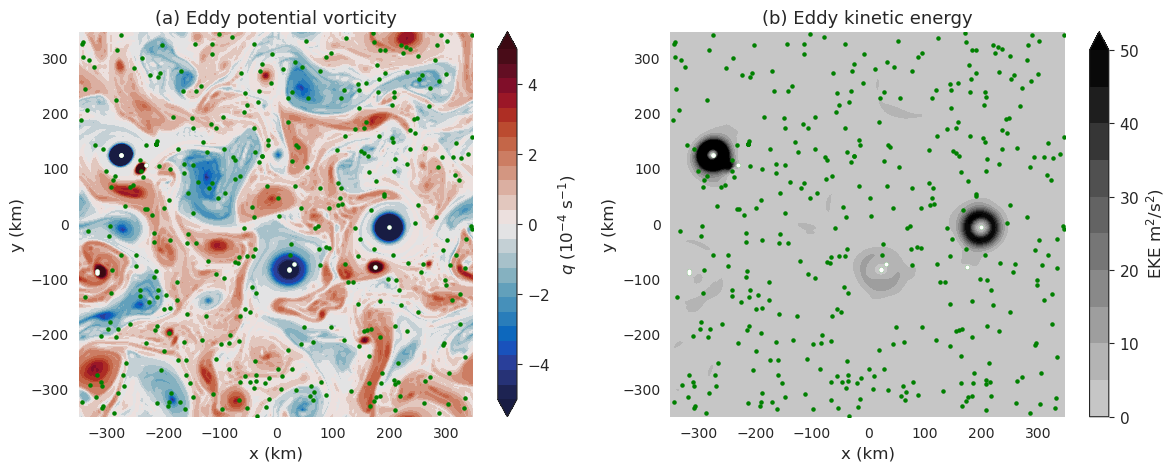

In [11]:
sns.set_style('white')
i = 799
print(t[i]/86400, 'days')

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap
cmap_grey = truncate_colormap(plt.get_cmap("Greys"), 0.3, 1.0)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
caxf1 = ax1.contourf(x/1e3,y/1e3,q[i+time_offset,0,:,:],cmap='cmo.balance',extend='both',levels=np.linspace(-5e-4,5e-4,25))#,alpha=0.7)
cbar1 = fig.colorbar(caxf1,ax=ax1,ticks= [-4e-4,-2e-4,0,2e-4,4e-4])
cbar1.ax.set_yticklabels([r'$-4$', r'$-2$', r'$0$', r'$2$', r'$4$'],fontsize=11)
cbar1.set_label(r'$q$ ($10^{-4}$ s$^{-1}$)',fontsize=12)
ax1.scatter(lon1[:,i]/1e3,lat1[:,i]/1e3,s=5,c='g',zorder=10)
ax1.scatter(lon1[anom,i]/1e3,lat1[anom,i]/1e3,s=5,c='white',zorder=10)
ax1.set_title('(a) Eddy potential vorticity',fontsize=13)

caxf2 = ax2.contourf(x/1e3,y/1e3,eke[i+time_offset,0,:,:],cmap=cmap_grey,extend='max',levels=np.arange(0,51,5))
cbar2 = fig.colorbar(caxf2,ax=ax2, ticks = [0,10,20,30,40,50])
cbar2.ax.set_yticklabels([r'$0$', r'$10$', r'$20$', r'$30$', r'$40$', r'$50$'],fontsize=11)
cbar2.set_label(r'EKE m$^2$/s$^2$)',fontsize=12)
ax2.scatter(lon1[:,i]/1e3,lat1[:,i]/1e3,s=5,c='g',zorder=10)
ax2.scatter(lon1[anom,i]/1e3,lat1[anom,i]/1e3,s=5,c='w',zorder=10)
ax2.set_title('(b) Eddy kinetic energy',fontsize=13)

for ax in [ax1,ax2]:
    ax.set_xlabel('x (km)',fontsize=12)
    ax.set_ylabel('y (km)',fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

#plt.savefig('../../Figures/particles_in_flow.pdf',bbox_inches='tight')